In [1]:
import os
import sys
import itk
import seaborn as sns
from json_minify import json_minify # to allow comments in json files
import json
import time
import ants
import glob
import shutil
import pandas as pd
import numpy as np
# import pydicom as pyd
# import dicom2nifti
from directory_tree import display_tree  # Nice tool to display directory trees (https://pypi.org/project/directory-tree/)

from datetime import timedelta, datetime
%matplotlib inline


In [2]:
def list_folder_content(path, show_hidden=False):
    if show_hidden:
        ddfldrlst = os.listdir(path)
    else:
        ddfldrlst = list(filter(lambda item: not item.startswith('.'),os.listdir(path)))      
    return ddfldrlst

def display_folder_list(file_list):
    print('\n'.join(f'[{idx}] - {file_idx}' for idx, file_idx in enumerate(file_list)))

def get_path_to_process(full_path):
    print('Folder content:')
    print(display_tree(full_path, header=True, string_rep=True, show_hidden=False, max_depth=2))
    folder_content = list_folder_content(full_path)
    # Ideally we'll have only one sub-folder inside the PreTreatment folder. If more than one, then we have to choose, but by default, we'll select the first one.
    idx_reg = 0
    if len(folder_content) > 1:
        display_folder_list(folder_content)
        idx_sel = input(f'Select the folder with the dataset_to_process to process (0-{len(folder_content)-1} or just press Enter to proceed with sub-folder {folder_content[idx_reg]}):')
        if idx_sel:
            idx_reg = int(idx_sel)
    path2data = os.path.join(full_path, folder_content[idx_reg])
    print(f'Will process {folder_content[idx_reg]}')
    return path2data

def check_time_points(path_to_check, nmax = 6):
    if path_to_check is not None:
        nr_of_folders = list_folder_content(path_to_check)
        print('Folder seems Ok:' if len(nr_of_folders)== nmax else f'Error! Check path {path_to_check} is the correct one:')
        display_tree(path_to_check, max_depth=1)
        return nr_of_folders if len(nr_of_folders) == nmax else None
    else:
        return None

def add_prefix_to_filename(full_path, prefix=None):
    # Assume the last part of the path is the filename (with extension)
    file_path, file_name_ext = os.path.split(full_path)
    if prefix:
        updated_filename = '_'.join([prefix, file_name_ext])
        return os.path.join(file_path, updated_filename)
    else:
        return prefix

def mutual_info_metric(volume1, volume2):
    """
    See https://antspy.readthedocs.io/en/latest/registration.html#ants.image_mutual_information
    For more complex/versatile image comparisons, see https://antspy.readthedocs.io/en/latest/utils.html#ants.image_similarity
    """
    mi_metric = ants.image_mutual_information(volume1, volume2)
    
    return mi_metric

def get_metrics(volume1, volume2, metric='mi', debug=False, sampling_pc=1.0):
    """
    See https://antspy.readthedocs.io/en/latest/utils.html#ants.image_similarity
    For more complex/versatile metrics, see https://antspy.readthedocs.io/en/latest/registration.html#ants.image_mutual_information    
    """
    if debug:
        start_time = time.perf_counter()
        print(''.join(['§']*100))
        print(f'§§§§§§§§§§§§ GET_METRICS: Timing the calculations of metric {metric}...')
    if metric == 'mi':
        val = ants.image_mutual_information(volume1, volume2)
    elif metric == 'mean_sq':
        val = ants.image_similarity(volume1, volume2, metric_type='MeanSquares', sampling_percentage=sampling_pc)
    elif metric == 'dist_corr':
        val = ants.image_similarity(volume1, volume2, metric_type='Correlation', sampling_percentage=sampling_pc)
    elif metric == 'mattes_mi':
        val = ants.image_similarity(volume1, volume2, metric_type='MattesMutualInformation', sampling_percentage=sampling_pc)
    elif metric == 'joint_hist_mi':
        val = ants.image_similarity(volume1, volume2, metric_type='JointHistogramMutualInformation', sampling_percentage=sampling_pc)
    else:
        val = None

    if debug:
        end_time = time.perf_counter()
        elp_time = end_time - start_time
        print(f'§§§§§§§§§§§§ GET_METRICS: Elapsed time: {elp_time:0.2f}[s]')
        print(''.join(['§']*100))


    return val

def getenv():
    """
    Requires sys and os modules:
    import sys
    import os
    Possible values for sys.platform are (https://docs.python.org/3/library/sys.html & https://stackoverflow.com/questions/446209/possible-values-from-sys-platform)
    ┍━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
    │  System             │ Value               │
    ┝━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━┥
    │ Linux               │ linux or linux2 (*) │
    │ Windows             │ win32               │
    │ Windows/Cygwin      │ cygwin              │
    │ Windows/MSYS2       │ msys                │
    │ Mac OS X            │ darwin              │
    │ OS/2                │ os2                 │
    │ OS/2 EMX            │ os2emx              │
    │ RiscOS              │ riscos              │
    │ AtheOS              │ atheos              │
    │ FreeBSD 7           │ freebsd7            │
    │ FreeBSD 8           │ freebsd8            │
    │ FreeBSD N           │ freebsdN            │
    │ OpenBSD 6           │ openbsd6            │
    │ AIX                 │ aix (**)            │
    ┕━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
    """
    if sys.platform == 'win32':
        env_home = 'HOMEPATH'
    elif (sys.platform == 'darwin') | (sys.platform == 'linux'):
        env_home = 'HOME'
    HOMEPATH = os.getenv(env_home)
    
    return HOMEPATH

def check_path_exist(path, file=False):
    """
    Flag FILE indicates the path contains a file name (FLAG=TRUE) or the path only points to a folder (FLAG=FALSE (Default))
    """
    if file:
        is_path = os.path.isfile(path)
    else:
        is_path = os.path.isdir(path)

    print(f'{"OK:" if is_path else "ERROR:"} Path to {"file" if file else "folder"} {path} does{"" if is_path else " NOT"} exist')

    return is_path


In [3]:
HOMEPATH = getenv()
SRCPATH = os.path.join(HOMEPATH, 'Data', 'fMRIBreastData')

DCMSRCFLDR = 'StudyData'
REFTEST = 'Test000'
OUTPUTFLDR = f'{os.sep}'.join(['output','summaries'])
TESTSFLDR = 'tests'
CFGFLDR = 'configFiles'

cfg_path = os.path.join(SRCPATH, CFGFLDR)
save_path = os.path.join(SRCPATH, OUTPUTFLDR)
# Check whether the folder SAVEPATH exists or not, if not, attempts to create it
os.makedirs(save_path, exist_ok=True)


In [4]:
DEBUGMODE = True
BATCHMODE = True # TRUE: it runs all dataset within INPUT_PATH; FALSE (DEFAULT): allows to pick a specific dataset to register


In [5]:
# Read the description for each test and arrange it as a table (dataframe)
# Loop over all dataset looking for a description.json file:
path_to_tests = os.path.join(SRCPATH, TESTSFLDR)
list_of_tests = sorted(list_folder_content(path_to_tests))
description_df = []
for test in list_of_tests:
    path_to_description = os.path.join(path_to_tests, test, 'description.json')
    if (os.path.isfile(path_to_description)):
        # json_normalize flattens the data frame. It works for relatively "simple" cases, not necessarily work when the json file is too nested or complex
        description_df.append(pd.json_normalize(json.loads(open(path_to_description).read())))

df = pd.concat(description_df)
# Ensure the Field SUMMARY is the last column (thanks to https://stackoverflow.com/questions/57301540/how-to-sort-python-list-by-keeping-some-elements-in-the-end)
df_reindex = df.columns.to_list()
df_reindex.sort(key=lambda x: x.startswith('Summary'))
df = df.reindex(df_reindex, axis=1)

df.to_csv(os.path.join(save_path, 'descriptions.csv'), index=False)


In [6]:
# Start reviewing the ROI csv dataset
ROICSVFLDR = f'{os.sep}'.join(['output','roi_csv'])
roicsv_path = os.path.join(SRCPATH, ROICSVFLDR)

# Get the list of csv files:
csv_list = list_folder_content(roicsv_path)

# Datafolder structure is:
if DEBUGMODE:
    display_tree(roicsv_path)
    print(f'Number of files: {len(csv_list)}')


roi_csv/
├── CR-Post-Treatment-20230120_Test000-RoiSet-Frame001.csv
├── CR-Post-Treatment-20230120_Test000-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test001-RoiSet-Frame001.csv
├── CR-Post-Treatment-20230120_Test002-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test003-RoiSet-Frame001.csv
├── CR-Post-Treatment-20230120_Test004-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test005-RoiSet-Frame001.csv
├── CR-Post-Treatment-20230120_Test006-RoiSet-Frame001.csv
├── CR-Post-Treatment-20230120_Test007-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test008-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test009-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test010-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test011-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test012-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test013-RoiSet-Frame002.csv
├── CR-Post-Treatment-20230120_Test014-RoiSet-Frame002.csv
├── CR-Pre-Treatment-20221212_Test000-RoiSet-Fr

* For the csv ROI data, the file format is as follows:

    ```dataID_TestNro-RoiSet-ReferenceFrame.csv```
* And each csv file must contain the following headers:

    ```Empty(index key),ROIName,ROIArea,MeanSignalIntensity (SI),StdDevSI,MinSI,MaxSI,SliceNro,FrameNro```
* The field ```FrameNro``` defines the timepoint, e.g. to plot the Mean SI for a particular dataset.
* The field ```ROI Name``` has the format:

    ```CurrImg:{sliceNro:03d}-{Location}-{Landmark}-{LandmarkIndex}:IJ Internal ID```
* The field ```sliceNro``` is formatted as integer with 3 digits (e.g. Slice 10 --> 010)
* The field ```Location``` indicates whether the ROI is in the Left Breast (LB) or Right Breast (RB) - see dictionary for more Locations
* The field ```Landmark``` indicates which structure covers the ROI, like ```Location``` is represented as 2 letters, according to the ROI dictionary
* The field ```LandmarkIndex``` indicates whether there are only one or more ROIs of the same Landmark in the same sliceNro



In [7]:
# Load the ROI dictionary:
dict_name = 'ROI_Dictionary.json'
roi_dict = json.loads(open(os.path.join(cfg_path, dict_name)).read())
roi_dict


{'locations': {'lb': 'left breast', 'rb': 'right breast'},
 'landmarks': {'tt': 'tumour tissue',
  'bv': 'blood vessel',
  'dt': 'duct',
  'gt': 'glandular tissue',
  'ft': 'fat tissue',
  'pm': 'pectoralis muscle',
  'mm': 'major muscle',
  'lg': 'ligament',
  'np': 'nipple',
  'ct': 'clip in tumour'}}

In [8]:
# Loop over the csv files, clean up the data and append them into a large dataframe
df_list = []
for csv_file in csv_list:
    csv_name, _ = os.path.splitext(csv_file)
    # From the filename derive dataID and main descriptors:
    dataID, ROIdesc = csv_name.split('_')
    TestNro, _, RefFrameNro = ROIdesc.split('-')
    # TestNro, RefFrameNro = [int(TestNro.replace('Test','')), int(RefFrameNro.replace('Frame',''))]

    if not DEBUGMODE:
        print(f'Processing file {csv_file}, please wait...')
    # Load the csv as a DataFrame and assign the empty column 0 as the Key (Index)
    csv_path = os.path.join(roicsv_path, csv_file)
    csv_as_df = pd.read_csv(csv_path, index_col=False)
    csv_as_df.rename(columns = {' ' : "Index"}, inplace=True)
    csv_as_df.set_index('Index', inplace=True)
    # Add the dataID and main descriptors to the DataFrame:
    cols2add = ['DataID', 'TestNro', 'RefFrameRef'] 
    cols_order = list(cols2add) + csv_as_df.columns.to_list()
    csv_as_df[cols2add] = [dataID, TestNro, RefFrameNro]
    # From the label and ROI dictionary, gets the full names of the location and landmark:
    # Eliminates the start and end limited by the ':':
    relevant_label_content = csv_as_df.Label.str.split(':', expand=True)[1]
    roi_descriptors = relevant_label_content.str.split('-', expand=True)
    roi_descriptors.rename(columns={0:'ROISlice', 1: 'Location', 2: 'Landmark', 3: 'LandmarkIndex'}, inplace=True)
    roi_descriptors['LandmarkIndex'] = roi_descriptors['LandmarkIndex'].astype(int)
    # Add the detail extracted, sort the columns and remove the Label column:
    cols_order += roi_descriptors.columns.to_list()
    csv_as_df[roi_descriptors.columns.values] = roi_descriptors.values
    csv_as_df = csv_as_df[cols_order]
    csv_as_df.drop(labels=['Label'], axis=1, inplace=True)
    df_list.append(csv_as_df)
    # Note: Slice and ROISlice are the same, they are redundant, but can be used as positive control to test the code

roi_df = pd.concat(df_list)

roi_df.to_csv(os.path.join(save_path, 'roi_csv_df.csv'))
roi_df.head()


,DataID,TestNro,RefFrameRef,Area,Mean,StdDev,Min,Max,Slice,Frame,ROISlice,Location,Landmark,LandmarkIndex
Index,,,,,,,,,,,,,,
1,JB-Pre-Treatment-20230405,Test001,Frame001,32.331,829.707,225.341,299.379,1207.173,75,1,s075,RB,TT,1
2,JB-Pre-Treatment-20230405,Test001,Frame001,32.331,1611.686,453.901,589.000,2437.000,75,2,s075,RB,TT,1
3,JB-Pre-Treatment-20230405,Test001,Frame001,32.331,1623.586,463.008,435.000,2483.000,75,3,s075,RB,TT,1
4,JB-Pre-Treatment-20230405,Test001,Frame001,32.331,1672.014,475.378,661.000,2625.000,75,4,s075,RB,TT,1
5,JB-Pre-Treatment-20230405,Test001,Frame001,32.331,1711.957,473.653,730.000,2628.000,75,5,s075,RB,TT,1


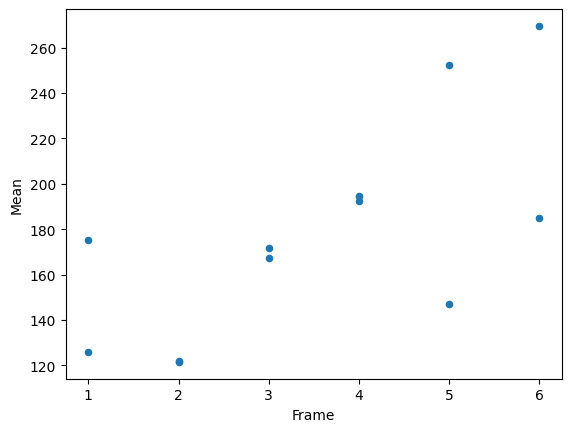

In [9]:
# Plot the time course of the tumour tissue areas for patient DC:
pattern_patient = 'DC-Post-Treatment'
testNro = 'Test004'
ROIofInt = 'FT'
time_course_plot = roi_df.loc[(roi_df['DataID'].str.startswith(pattern_patient)) &
                              (roi_df['Landmark'] == ROIofInt) &
                              ((roi_df['TestNro'] == testNro) | (roi_df['TestNro'] == 'Test008'))].plot(kind='scatter', y='Mean',x='Frame')


In [10]:
# Now, load the registration summary:
REGCSVFLDR = f'{os.sep}'.join(['output','reg_csv'])
regcsv_path = os.path.join(SRCPATH, REGCSVFLDR)

# Get the list of csv files:
regcsv_list = list_folder_content(regcsv_path)
default_csv_idx = 0

# Datafolder structure is:
if DEBUGMODE:
    display_tree(regcsv_path)
    print(f'Number of files: {len(regcsv_list)}')

if len(regcsv_list) > 1:
    print('Select a file to process:')
    display_folder_list(regcsv_list)
    csv_idx = input(f'Pick a valid index {tuple(range(len(regcsv_list)))} or type "d" to use the default ({default_csv_idx}):')
    if csv_idx == 'd':
        if DEBUGMODE:
            print(f'Selecting index {default_csv_idx} (default value)')
        csv_idx = default_csv_idx
    else:
        csv_idx = int(csv_idx)
else:
    csv_idx = default_csv_idx

regcsv_to_process = regcsv_list[csv_idx]
print(f'Loading {regcsv_to_process} file')


reg_csv/
├── summary_results_metrics_20240326_sampling_frac_0.85.csv
└── summary_results_metrics_20240328_sampling_frac_0.85.csv
Number of files: 2
Select a file to process:
[0] - summary_results_metrics_20240326_sampling_frac_0.85.csv
[1] - summary_results_metrics_20240328_sampling_frac_0.85.csv
Loading summary_results_metrics_20240328_sampling_frac_0.85.csv file


In [11]:
cols_to_show = ['Mutual Information', 'Mean Squares', 'Correlation', 'Mattes Mutual Information', 'Joint Histogram Mutual Information']
reg_df = pd.read_csv(os.path.join(regcsv_path, regcsv_to_process))
reg_df.tail()


,IdxKey,TestNro,PatientID,PatientVisit,RegistrationMethod,FixedVolume,Registered2Itself,BiasCorrection,HistogramMatching,TimePoint,Mutual Information,Mean Squares,Correlation,Mattes Mutual Information,Joint Histogram Mutual Information
1321,1321,Test013,RICE00-RICE001,RICE001-20221026,ANTs,2,True,n4itk,True,2,-1.056635,0.000000,-1.000000,-1.345865,-0.428083
1322,1322,Test013,RICE00-RICE001,RICE001-20221026,ANTs,2,True,n4itk,True,3,-0.627257,60915.851562,-0.894009,-0.777822,-0.360942
1323,1323,Test013,RICE00-RICE001,RICE001-20221026,ANTs,2,True,n4itk,True,4,-0.624548,61167.140625,-0.893548,-0.775460,-0.355754
1324,1324,Test013,RICE00-RICE001,RICE001-20221026,ANTs,2,True,n4itk,True,5,-0.618624,63349.851562,-0.889680,-0.768324,-0.353459
1325,1325,Test013,RICE00-RICE001,RICE001-20221026,ANTs,2,True,n4itk,True,6,-0.618961,63430.937500,-0.889405,-0.769229,-0.357525


# Comparison 0
Mutual information respect to pre-contrast and 1st post-contrast
## Raw data

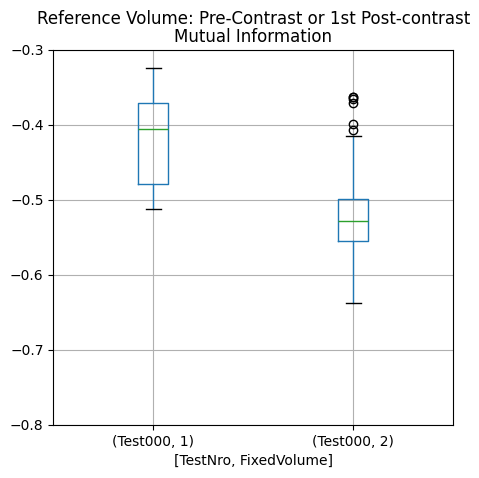

In [22]:
# EvaluationID 0: MI reference volumes
evaluation = 'C1.ID00'
reg_method = 'Raw'
reg_to_itself = False
tests_to_compare = ['Test000']
title = f'Reference Volume: Pre-Contrast or 1st Post-contrast'
img_name = f'Comparison_{evaluation}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'

group_by = ['TestNro', 'FixedVolume']
sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['Registered2Itself'] == reg_to_itself) & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'FixedVolume']
fig_size = (5.0, 5.0)

img_name = f'Comparison_{evaluation}_Test_{tests_to_compare[0]}.png'
boxplot_mi = sub_set.boxplot(column=cols_to_show[0],
                                     by=group_by,
                                     sharey=False,
                                     figsize=fig_size,
                                     layout=[1,1])

ylims = {'mi': [-0.8, -0.30],
         'meansq': [0, 350000],
         'corr': [-1.0, -0.4],
         'mattesmi': [-1.0, -0.3],
         'jhmi': [-0.45, -0.2]
}


curr_figure = boxplot_mi.get_figure()
_ = curr_figure.suptitle(title)
# for idx, ax in enumerate(boxplot_mi.ravel()):
    # ax.set_ylim(ylims[list(ylims.keys())[idx]])
boxplot_mi.set_ylim(ylims[list(ylims.keys())[0]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()

table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'))



# Comparison 1
Which reference volume is better: Pre-Contrast or 1st Post-contrast?
## Registration Method: Elastix, Do not register the fixed volume to istself

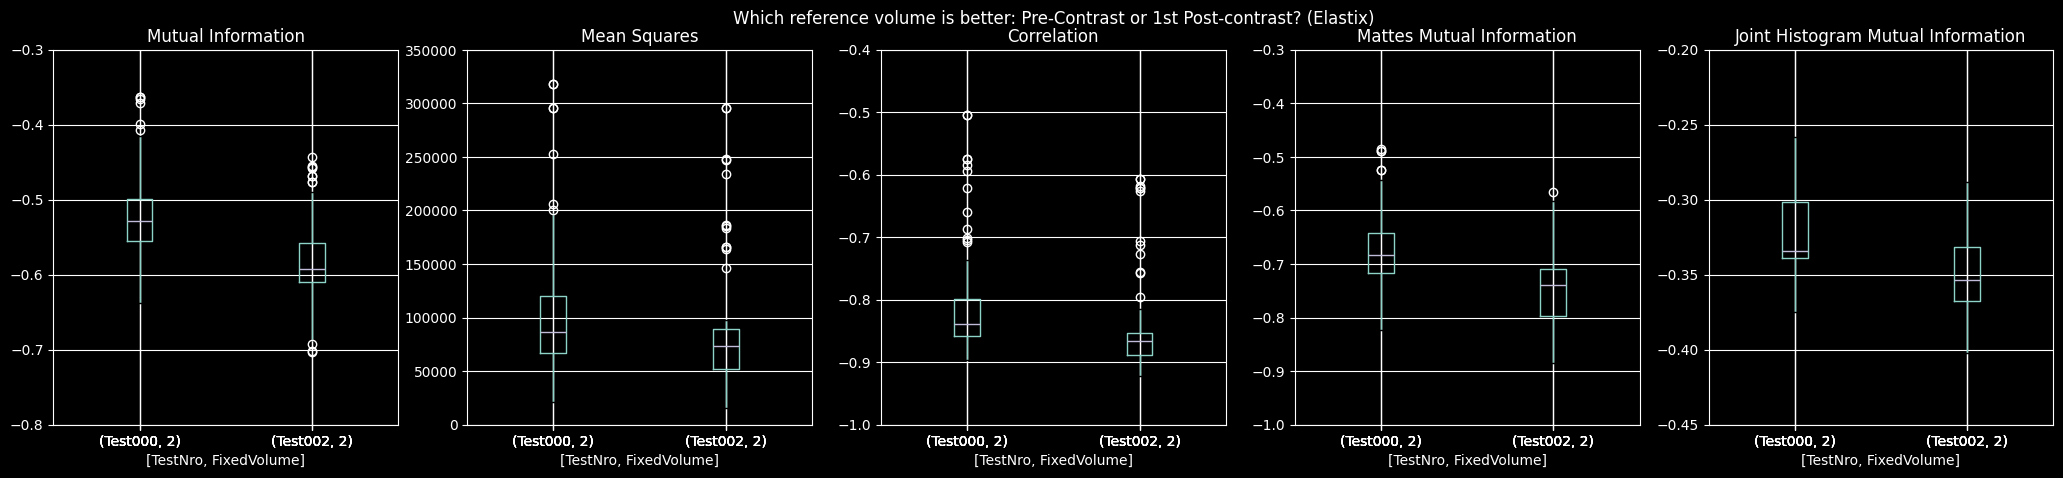

In [14]:
# EvaluationID 1.1: Registration Method: Elastix, Do not register the fixed volume to istself
evaluation = 'C1.ID01'
reg_method = 'Elastix'
reg_to_itself = False
tests_to_compare = ['Test000', 'Test001', 'Test002']
ref_vol = 2 # Still useful to arrange the plot as a single row, but have to try with both, 1 and 2
title = f'Which reference volume is better: Pre-Contrast or 1st Post-contrast? ({reg_method})'
img_name = f'Comparison_{evaluation}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'

group_by = ['TestNro', 'FixedVolume']
sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['Registered2Itself'] == reg_to_itself) & 
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'FixedVolume']
fig_size = (25.0, 5.0)

img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'
boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=fig_size,
                                     layout=[1,5])

ylims = {'mi': [-0.8, -0.30],
         'meansq': [0, 350000],
         'corr': [-1.0, -0.4],
         'mattesmi': [-1.0, -0.3],
         'jhmi': [-0.45, -0.2]
}


curr_figure = boxplot_mi[0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()

table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'))



## Registration Method: ANTs, Do not register the fixed volume to istself

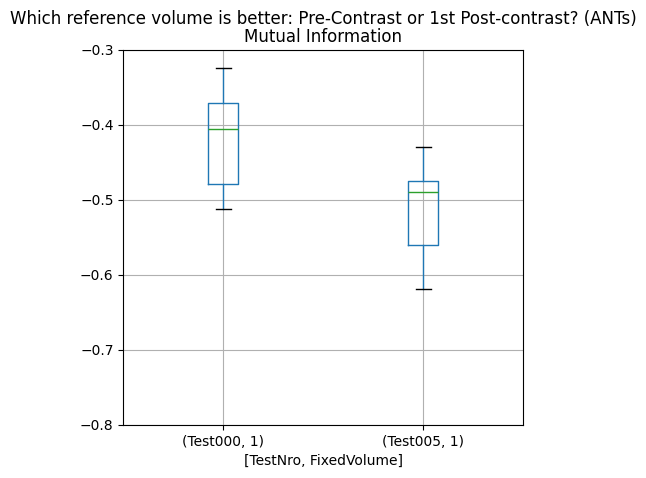

In [25]:
# EvaluationID 10: Registration Method: ANTs, Do not register the fixed volume to istself
evaluation = 'C1.ID10'
reg_method = 'ANTs'
reg_to_itself = False
tests_to_compare = ['Test000', 'Test005', 'Test007']
ref_vol = 1 # Still useful to arrange the plot as a single row, but have to try with both, 1 and 2
title = f'Which reference volume is better: Pre-Contrast or 1st Post-contrast? ({reg_method})'
img_name = f'Comparison_{evaluation}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['Registered2Itself'] == reg_to_itself)  & 
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'FixedVolume']

img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'
boxplot_mi = sub_set.boxplot(column=cols_to_show[0],
                                     by=group_by,
                                     sharey=False,
                                     figsize=fig_size,
                                     layout=[1,1])

# curr_figure = boxplot_mi[0].get_figure()
curr_figure = boxplot_mi.get_figure()
_ = curr_figure.suptitle(title)
boxplot_mi.set_ylim(ylims[list(ylims.keys())[0]])
# for idx, ax in enumerate(boxplot_mi.ravel()):
#     ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Registration Method: ELASTIX, Do register the fixed volume to istself

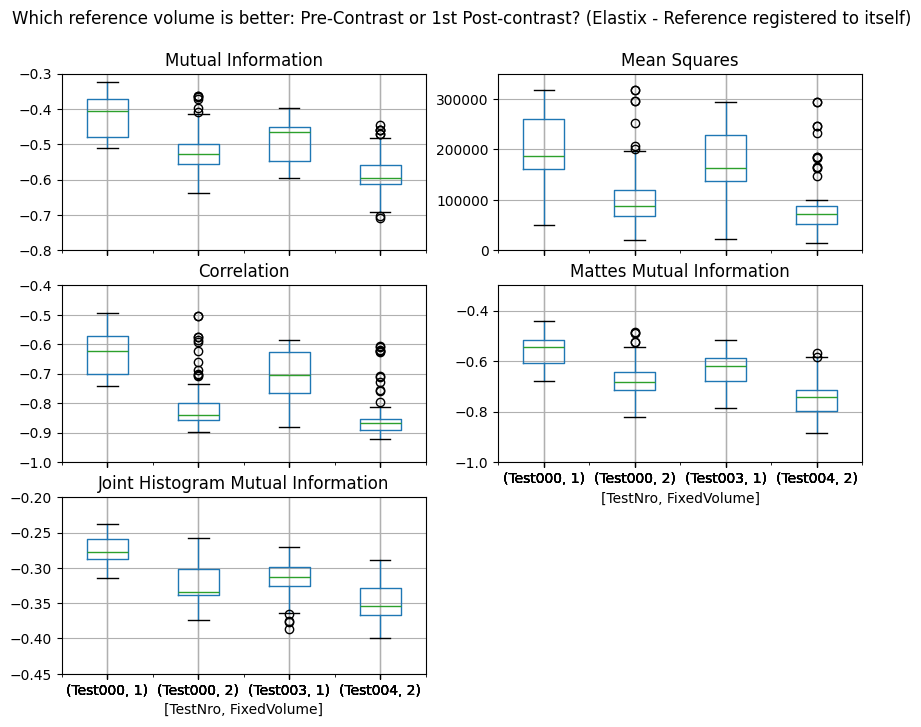

In [25]:
# EvaluationID 6: Registration Method: ELASTIX, Do register the fixed volume to istself
evaluation = 'C1.ID06'
reg_method = 'Elastix'

reg_to_itself = True
tests_to_compare = ['Test000', 'Test003', 'Test004']
title = f'Which reference volume is better: Pre-Contrast or 1st Post-contrast? ({reg_method} - Reference registered to itself)'
img_name = f'Comparison_{evaluation}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['Registered2Itself'] == reg_to_itself)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'FixedVolume']
fig_size = (10.0, 8.0)

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))


curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Registration Method: ANTs, Do not register the fixed volume to istself

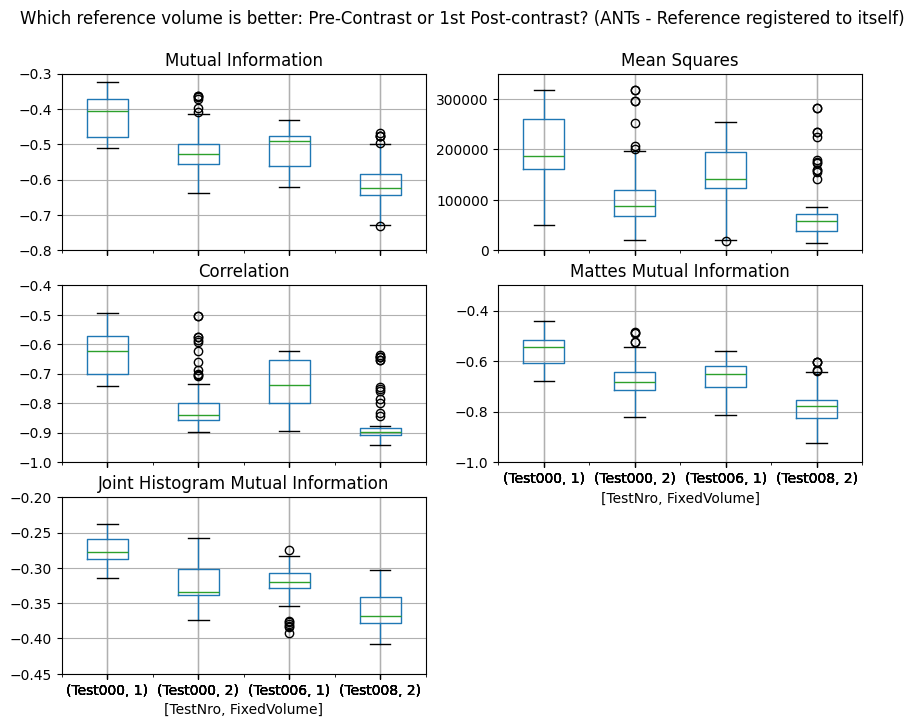

In [26]:
# EvaluationID 11: Registration Method: ANTs, Do not register the fixed volume to istself
evaluation = 'C1.ID11'
reg_method = 'ANTs'

reg_to_itself = True
tests_to_compare = ['Test000', 'Test006', 'Test008']
title = f'Which reference volume is better: Pre-Contrast or 1st Post-contrast? ({reg_method} - Reference registered to itself)'
img_name = f'Comparison_{evaluation}_RegMethod_{reg_method}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                        (reg_df['Registered2Itself'] == reg_to_itself)  & 
                        (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'FixedVolume']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


# Comparison 2
Which registration algorithm to choose?
## Pre-Contrast as reference, do not register the fixed volume to istself

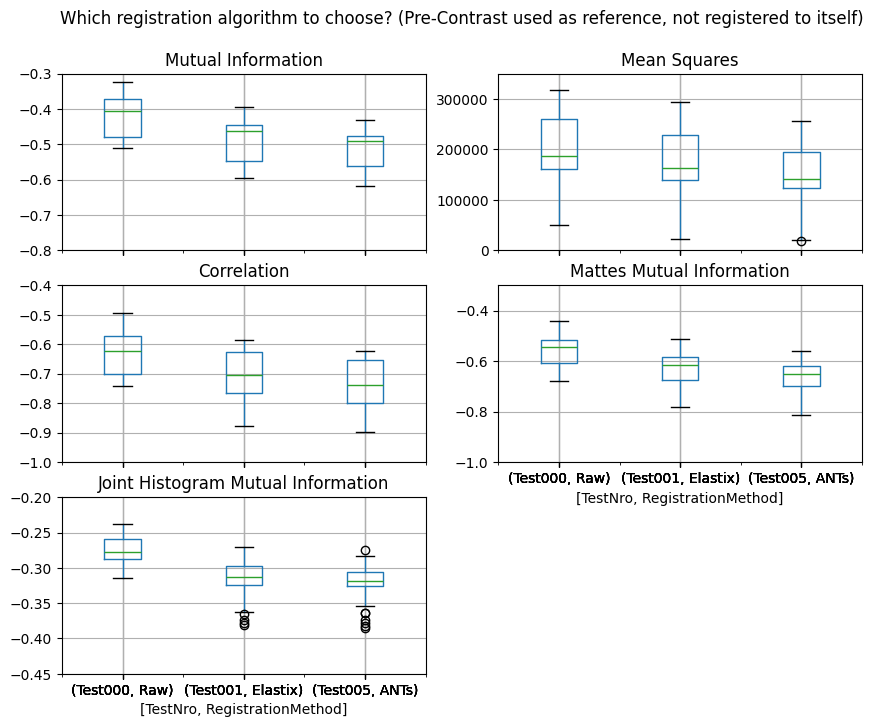

In [27]:
# EvaluationID 03: Reference is pre-contrast, do not register the fixed volume to istself
evaluation = 'C2.ID03'
ref_vol = 1
reg_to_itself = False
tests_to_compare = ['Test000', 'Test001', 'Test005']

title = f'Which registration algorithm to choose? (Pre-Contrast used as reference, not registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['Registered2Itself'] == reg_to_itself)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'RegistrationMethod']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

ylims = {'mi': [-0.8, -0.30],
         'meansq': [0, 350000],
         'corr': [-1.0, -0.4],
         'mattesmi': [-1.0, -0.3],
         'jhmi': [-0.45, -0.2]
}

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Reference is 1st post-contrast, do not register the fixed volume to istself

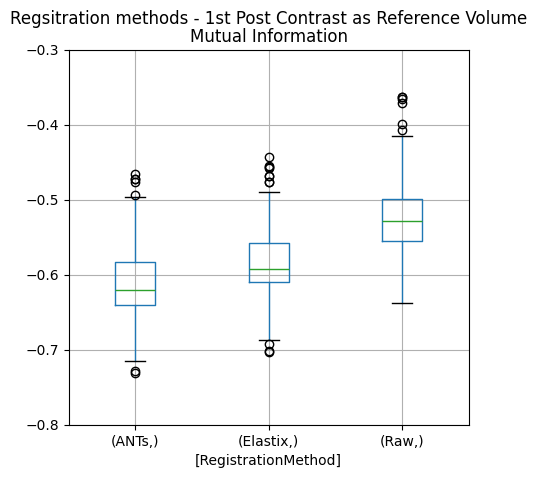

In [29]:
# EvaluationID 05: Reference is pre-contrast, do not register the fixed volume to istself
evaluation = 'C2.ID05'
ref_vol = 2
reg_to_itself = False
tests_to_compare = ['Test000', 'Test002', 'Test007']

title = f'Regsitration methods - 1st Post Contrast as Reference Volume'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['Registered2Itself'] == reg_to_itself) &
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['RegistrationMethod']

boxplot_mi = sub_set.boxplot(column=cols_to_show[0],
                                     by=group_by,
                                     sharey=False,
                                     figsize=(5.0, 5.0))

# curr_figure = boxplot_mi[0][0].get_figure()
curr_figure = boxplot_mi.get_figure()
_ = curr_figure.suptitle(title)
# for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
#     ax.set_ylim(ylims[list(ylims.keys())[idx]])
boxplot_mi.set_ylim(ylims[list(ylims.keys())[0]])

curr_figure.savefig(os.path.join(save_path, img_name))
desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Reference is pre-contrast, DO register the fixed volume to istself

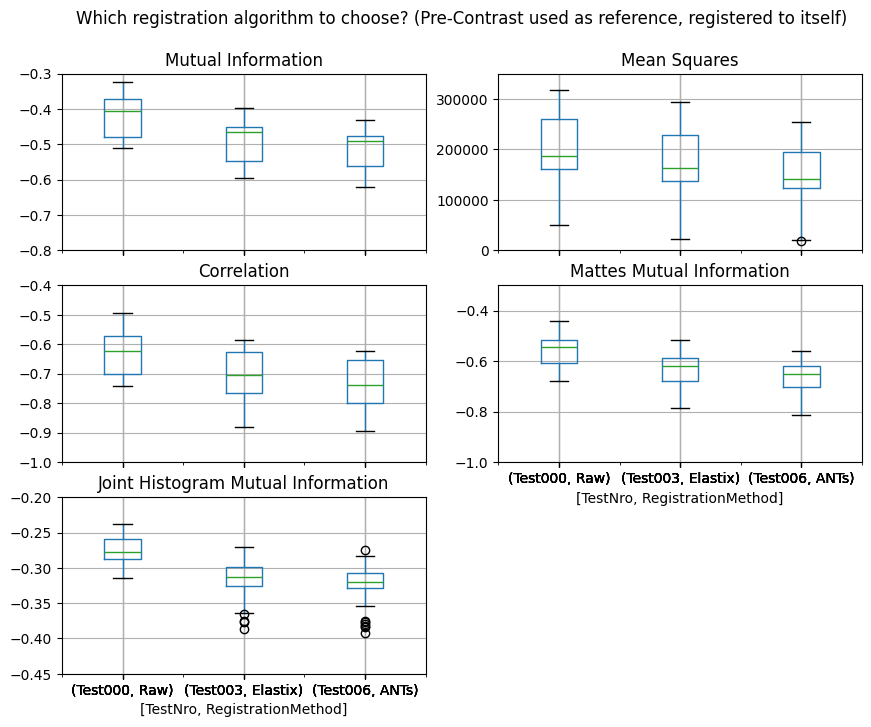

In [29]:
# EvaluationID 07: Reference is pre-contrast, DO register the fixed volume to istself
evaluation = 'C2.ID07'
ref_vol = 1
reg_to_itself = True
tests_to_compare = ['Test000', 'Test003', 'Test006']

title = f'Which registration algorithm to choose? (Pre-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['Registered2Itself'] == reg_to_itself)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'RegistrationMethod']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Reference is 1st post-contrast, DO register the fixed volume to istself

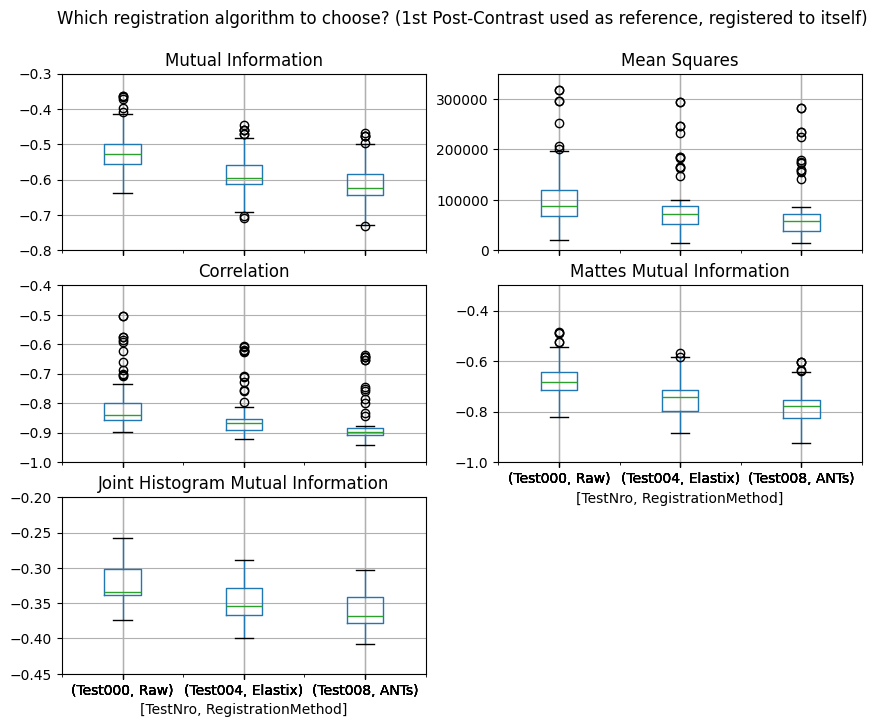

In [30]:
# EvaluationID 08: Reference is pre-contrast, DO register the fixed volume to istself
evaluation = 'C2.ID08'
ref_vol = 2
reg_to_itself = True
tests_to_compare = ['Test000', 'Test004', 'Test008']

title = f'Which registration algorithm to choose? (1st Post-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_Reg2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['Registered2Itself'] == reg_to_itself)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'RegistrationMethod']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


# Comparison 3
Effect of registering the Fixed Volume to itself
## Registration method: Elastix, Pre-Contrast as reference

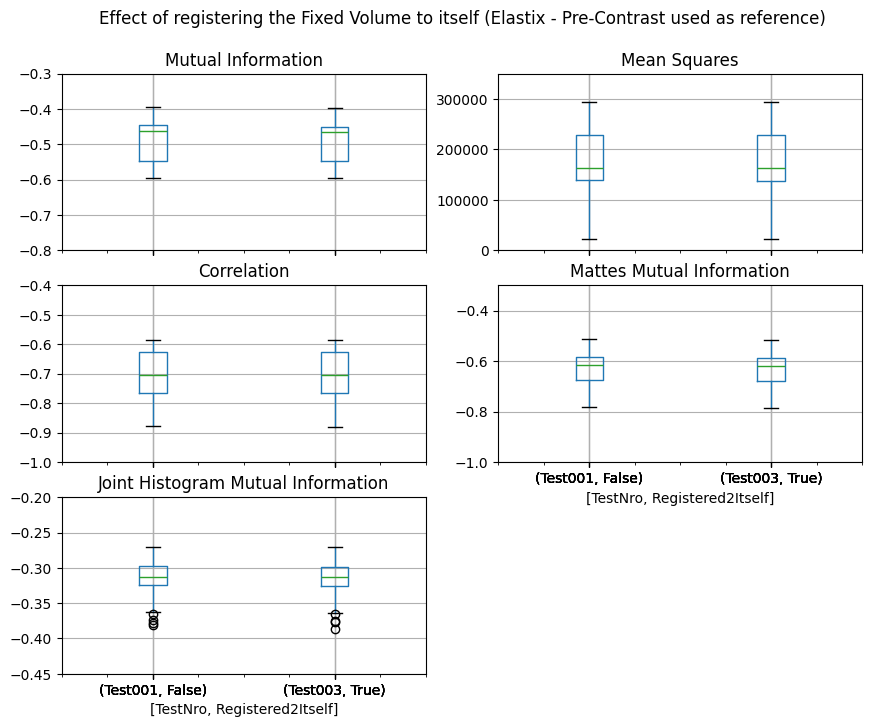

In [32]:
# EvaluationID 02: Registration method: Elastix, Pre-Contrast as reference
evaluation = 'C3.ID02'
ref_vol = 1
reg_method = 'Elastix'
tests_to_compare = ['Test000', 'Test001', 'Test003']

title = f'Effect of registering the Fixed Volume to itself ({reg_method} - Pre-Contrast used as reference)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]


group_by = ['TestNro', 'Registered2Itself']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

ylims = {'mi': [-0.8, -0.30],
         'meansq': [0, 350000],
         'corr': [-1.0, -0.4],
         'mattesmi': [-1.0, -0.3],
         'jhmi': [-0.45, -0.2]
}

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Registration method: Elastix, 1st Post-Contrast as reference

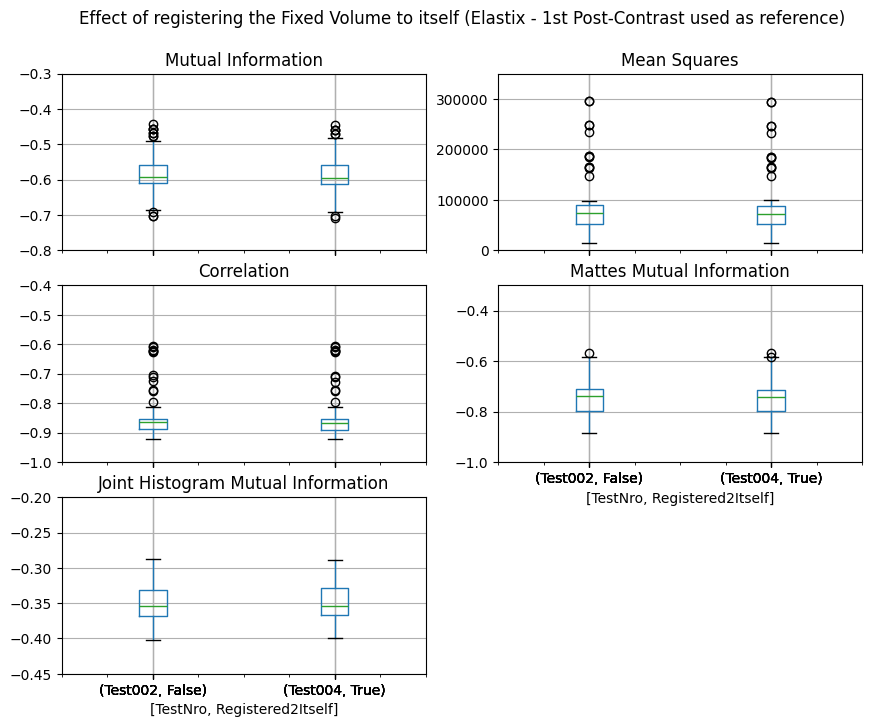

In [33]:
# EvaluationID 04: Registration method: Elastix, 1st Post-Contrast as reference
evaluation = 'C3.ID04'
ref_vol = 2
reg_method = 'Elastix'
tests_to_compare = ['Test000', 'Test002', 'Test004']

title = f'Effect of registering the Fixed Volume to itself ({reg_method} - 1st Post-Contrast used as reference)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'Registered2Itself']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Registration method: ANTs, Pre-Contrast as reference

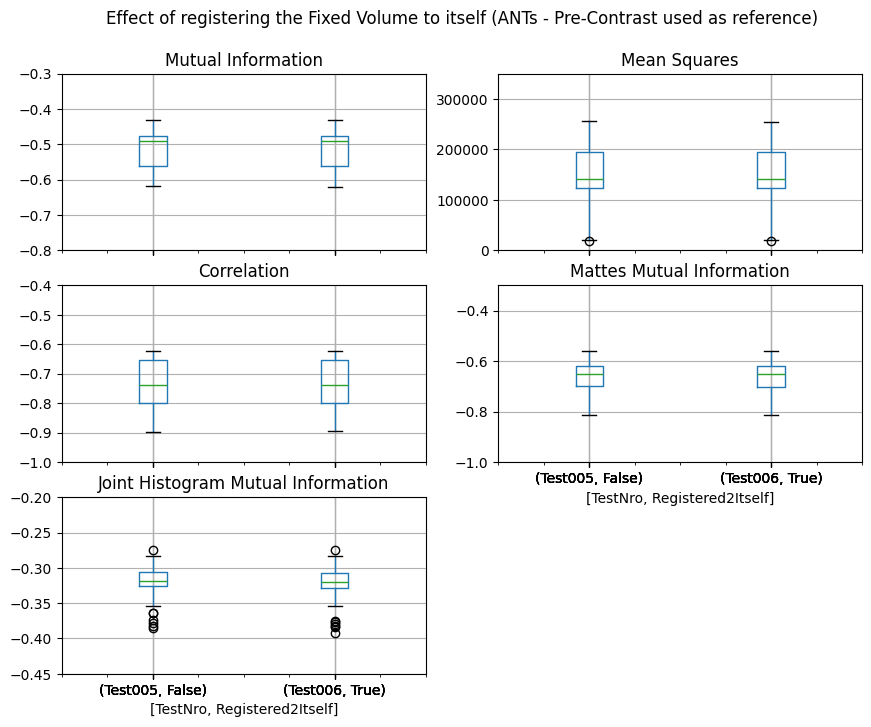

In [34]:
# EvaluationID 09: Registration method: ANTs, Pre-Contrast as reference
evaluation = 'C3.ID09'
ref_vol = 1
reg_method = 'ANTs'
tests_to_compare = ['Test000', 'Test005', 'Test006']

title = f'Effect of registering the Fixed Volume to itself ({reg_method} - Pre-Contrast used as reference)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'Registered2Itself']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Registration method: ANTs, 1st Post-Contrast as reference

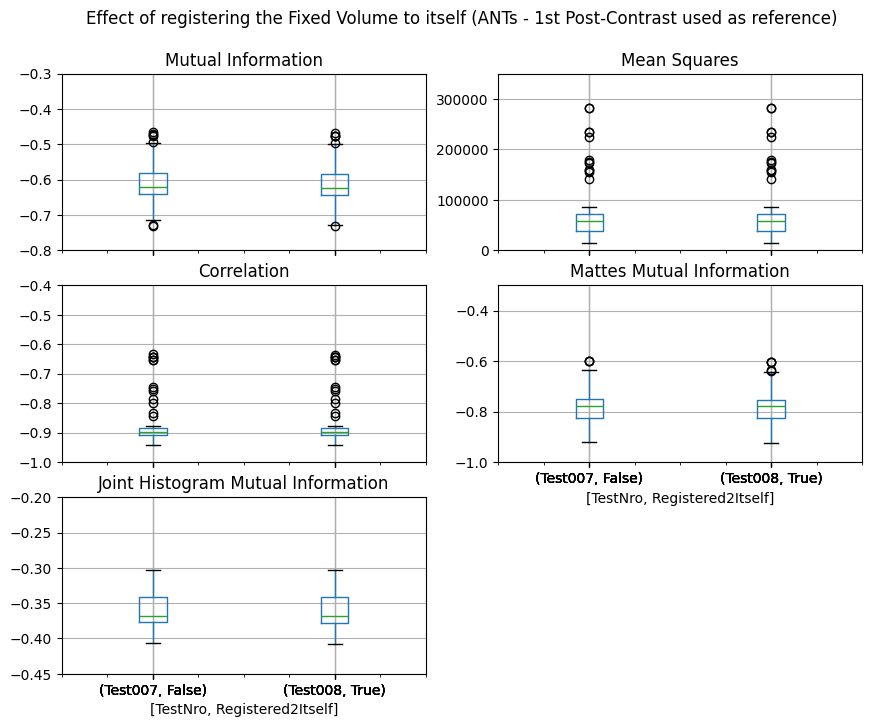

In [35]:
# EvaluationID 12: Registration method: ANTs, 1st Post-Contrast as reference
evaluation = 'C3.ID12'
ref_vol = 2
reg_method = 'ANTs'
tests_to_compare = ['Test000', 'Test007', 'Test008']

title = f'Effect of registering the Fixed Volume to itself ({reg_method} - 1st Post-Contrast used as reference)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'Registered2Itself']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


# Comparison 4
Effect of Applying Histogram Matching between moving and fixed volume, prior to run the registration. In here, we use the best combination derived in the previous comparisons, i.e.:
* Reference Volume: 1st Post-Contrast
* Ref Volume Registered to itself (i.e. flag=TRUE)

## Registration method: Elastix

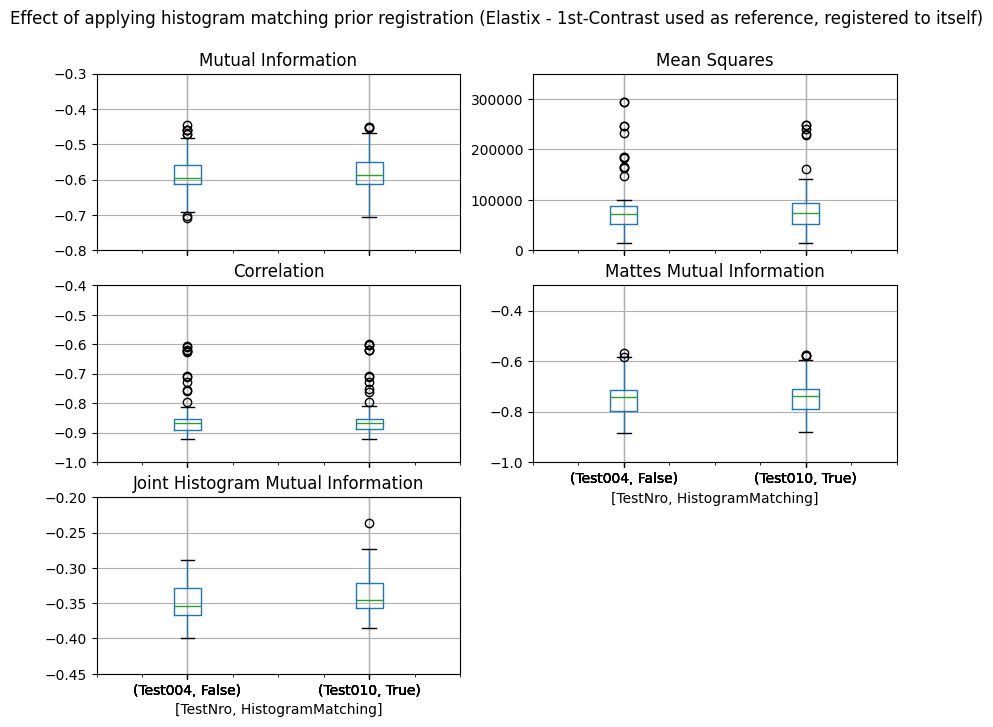

In [36]:
# EvaluationID 14: Effect of applying Histogram Matching prior to registration
evaluation = 'C4.ID14'
ref_vol = 2
reg_to_itself = True
reg_method = 'Elastix'
tests_to_compare = ['Test010', 'Test004']

title = f'Effect of applying histogram matching prior registration ({reg_method} - 1st-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}_Registered2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  &
                     (reg_df['Registered2Itself'] == reg_to_itself) & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'HistogramMatching']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

ylims = {'mi': [-0.8, -0.30],
         'meansq': [0, 350000],
         'corr': [-1.0, -0.4],
         'mattesmi': [-1.0, -0.3],
         'jhmi': [-0.45, -0.2]
}

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Registration method: ANTs
It is not possible to assess ANTs with and without histogram matching. As I found [here](), ANTsPy has the option ```--use-histogram``` set by default to 1, if wanted to change, then it must be re-compiled with the option.

What we can assess, is the effect of histogram matching and registration methods, i.e. Elastix with histogram matching and ANTs with the same options. 

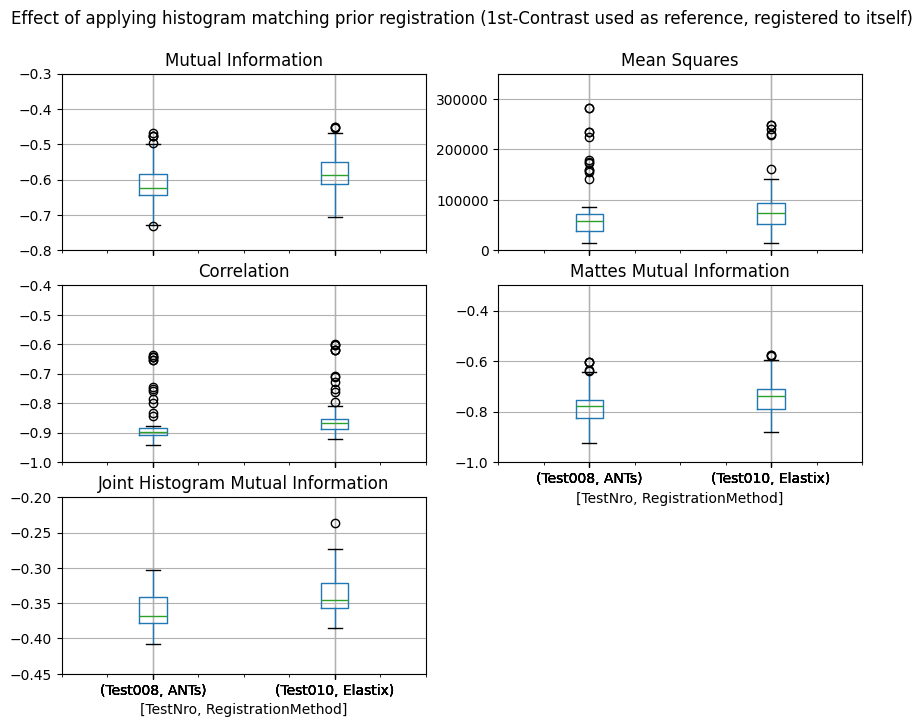

In [37]:
# EvaluationID 18: Effect of applying Histogram Matching prior to registration together with the registration method
evaluation = 'C4.ID18'
ref_vol = 2
reg_to_itself = True
histogram_matching = True
tests_to_compare = ['Test010', 'Test008']

title = f'Effect of applying histogram matching prior registration (1st-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_HistoMatch_{histogram_matching}_Registered2Itself_{reg_to_itself}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['Registered2Itself'] == reg_to_itself) & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'RegistrationMethod']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))


curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Histogram Matching effect with Bias correction field

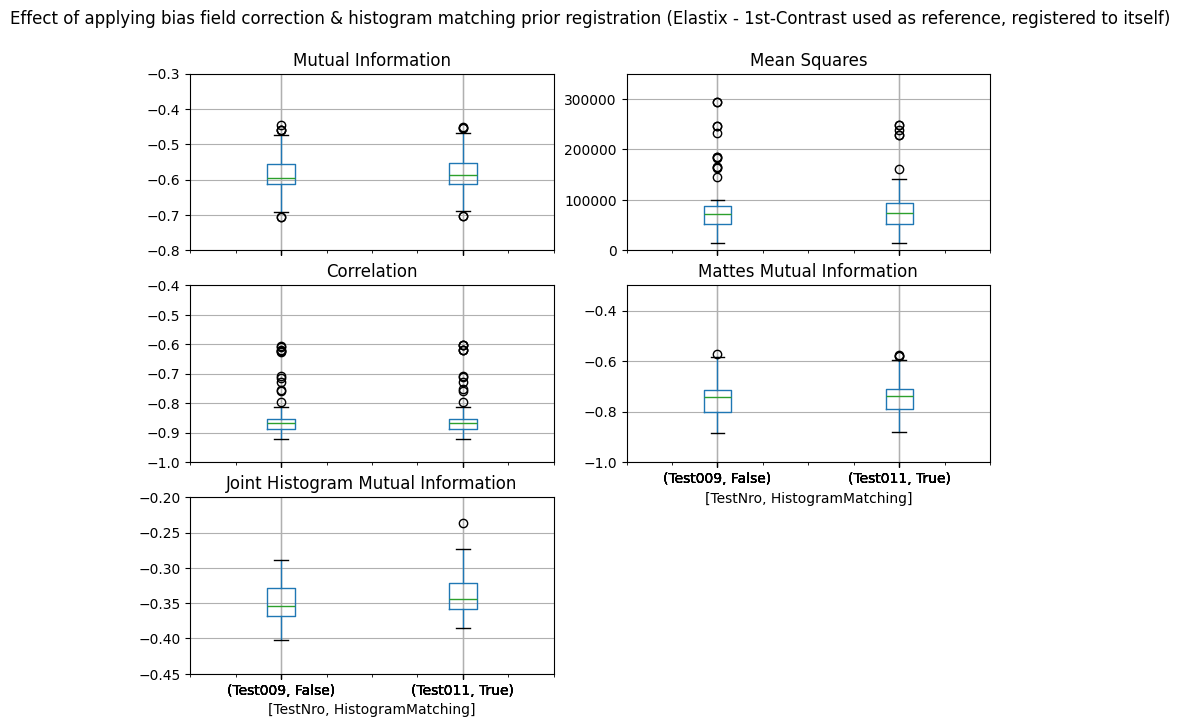

In [38]:
# EvaluationID 15: Effect of applying Bias Field correction with Histogram matching, prior to registration
evaluation = 'C4.ID15'
ref_vol = 2
reg_to_itself = True
reg_method = 'Elastix'
bias_correction = 'N4ITK'
tests_to_compare = ['Test011', 'Test009']

title = f'Effect of applying bias field correction & histogram matching prior registration ({reg_method} - 1st-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}_Registered2Itself_{reg_to_itself}_BiasCorrection_{bias_correction}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  &
                     (reg_df['Registered2Itself'] == reg_to_itself) &
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'HistogramMatching']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))


curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


# Comparison 5
Effect of Bias Field Correction into the registration. This is run prior to run the registration. In here, we use the best combination derived in the previous comparisons, i.e.:
* Reference Volume: 1st Post-Contrast
* Ref Volume Registered to itself (i.e. flag=TRUE)

## Registration method: Elastix

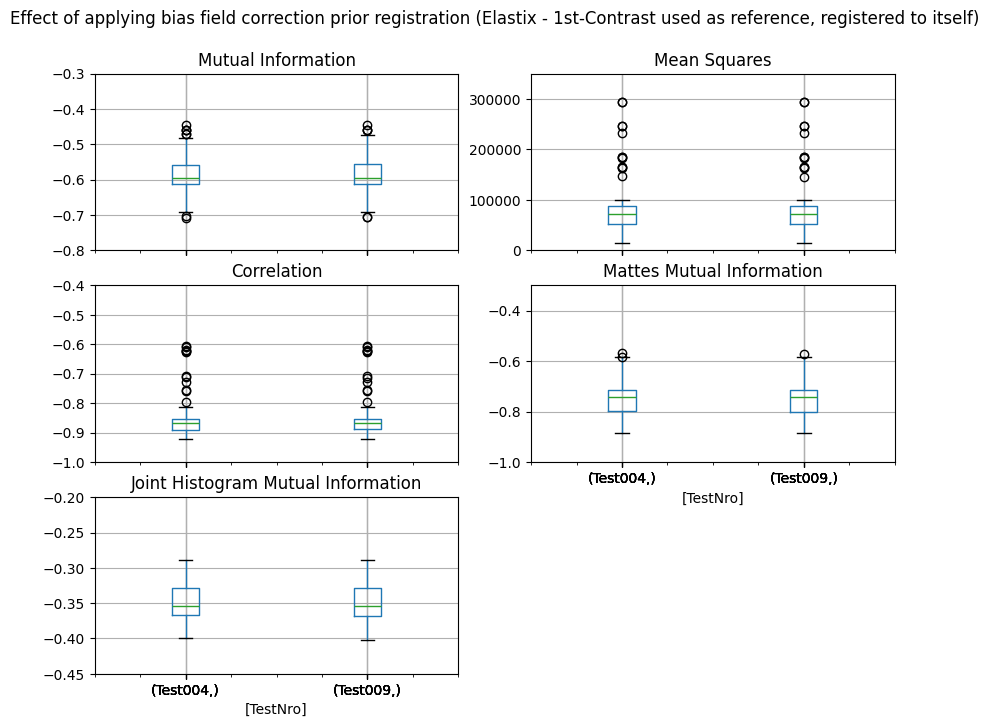

In [40]:
# EvaluationID 13: Effect of applying Bias Field correction prior to registration
evaluation = 'C5.ID13'
ref_vol = 2
reg_to_itself = True
reg_method = 'Elastix'
histogram_matching = False
tests_to_compare = ['Test009', 'Test004']

title = f'Effect of applying bias field correction prior registration ({reg_method} - 1st-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}_Registered2Itself_{reg_to_itself}_HistogramMatching_{histogram_matching}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  &
                     (reg_df['Registered2Itself'] == reg_to_itself) & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro']#, 'BiasCorrection']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

ylims = {'mi': [-0.8, -0.30],
         'meansq': [0, 350000],
         'corr': [-1.0, -0.4],
         'mattesmi': [-1.0, -0.3],
         'jhmi': [-0.45, -0.2]
}

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


## Bias Correction Field effect with Histogram Matching

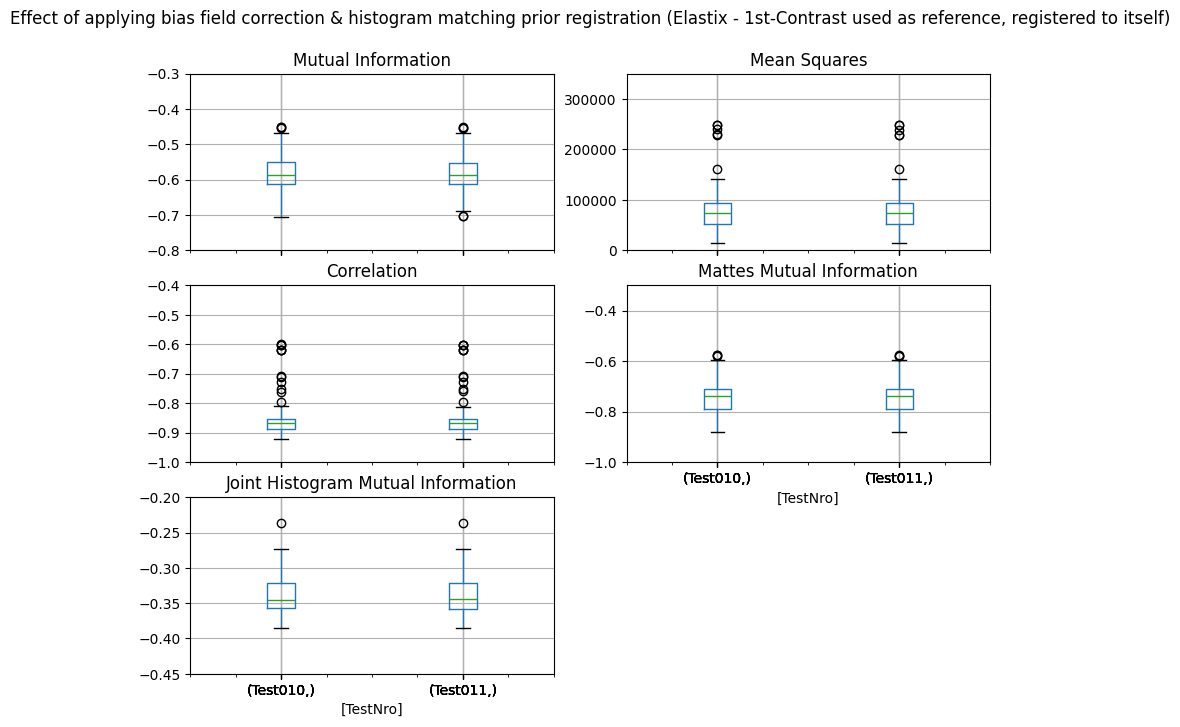

In [42]:
# EvaluationID 16: Effect of applying Bias Field correction with Histogram matching, prior to registration
evaluation = 'C5.ID16'
ref_vol = 2
reg_to_itself = True
reg_method = 'Elastix'
histogram_matching = True
tests_to_compare = ['Test011', 'Test010']

title = f'Effect of applying bias field correction & histogram matching prior registration ({reg_method} - 1st-Contrast used as reference, registered to itself)'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_RegMethod_{reg_method}_Registered2Itself_{reg_to_itself}_HistogramMatching_{histogram_matching}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['RegistrationMethod'] == reg_method)  &
                     (reg_df['Registered2Itself'] == reg_to_itself) & 
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro']#, 'BiasCorrection']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))

# ylims = {'mi': [-0.8, -0.30],
#          'meansq': [0, 350000],
#          'corr': [-1.0, -0.4],
#          'mattesmi': [-1.0, -0.3],
#          'jhmi': [-0.5, -0.1]
# }

curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')


# Comparison 6
Finally, assess the registration method, considering the following flags:
* Reference Volume: 1st Post-Contrast
* Fixed Volume registered to itself: True
* Histogram Matching: True (assume ANTs has it set to True by default)
* Bias Field Correction: N4ITK

## Registration

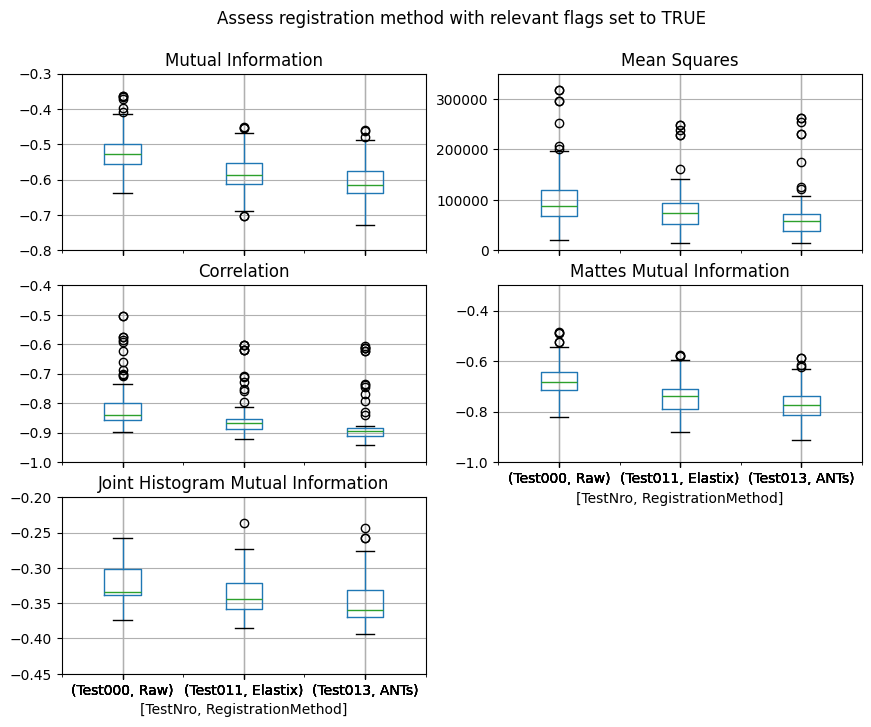

In [43]:
# EvaluationID 17: Assess registration method with relevant flags set to TRUE
evaluation = 'C6.ID17'
ref_vol = 2
reg_to_itself = True
histogram_matching = True
bias_correction = 'N4ITK'
tests_to_compare = ['Test000', 'Test011', 'Test013']

title = f'Assess registration method with relevant flags set to TRUE'
img_name = f'Comparison_{evaluation}_RefVol_{ref_vol}_Registered2Itself_{reg_to_itself}_HistogramMatching_{histogram_matching}_BiasCorrection_{bias_correction}.png'

sub_set = reg_df.loc[(reg_df['TestNro'].isin(tests_to_compare)) &
                     (reg_df['FixedVolume'] == ref_vol) &
                     (reg_df['Registered2Itself'] == reg_to_itself) &
                     (reg_df['TimePoint'] != reg_df['FixedVolume'])]

group_by = ['TestNro', 'RegistrationMethod']

boxplot_mi = sub_set.boxplot(column=cols_to_show,
                                     by=group_by,
                                     sharey=False,
                                     figsize=(10.0, 8.0))


curr_figure = boxplot_mi[0][0].get_figure()
_ = curr_figure.suptitle(title)
for idx, ax in enumerate(boxplot_mi.ravel()[:-1]):
    ax.set_ylim(ylims[list(ylims.keys())[idx]])

curr_figure.savefig(os.path.join(save_path, img_name))

desc_stats = sub_set.groupby(group_by).describe()
table_df = desc_stats[cols_to_show]['Mutual Information'][['mean','std', '50%']]
table_df['comparison'] = evaluation
table_df.to_csv(os.path.join(save_path, 'tables.csv'), mode='a')
